# One Integration Schwarzschild Black Hole

<ul id="top">
    <li><a href="#Loading-packages-and-functions">Loading packages and functions</a></li>
    <li><a href="#Definition-of-the-problem">Definition of the problem</a></li>
    <li><a href="#Integration">Integration</a></li>
    <li><a href="#Error-in-energy">Error in energy</a></li>
    <li><a href="#Error-in-solution">Error in solution</a></li>
</ul>

## Loading packages and functions

In [1]:
using LinearAlgebra
using Plots


PATH_IRKGL="../../../../IRKGaussLegendre.jl-master/IRKGaussLegendre.jl-master/"
include(string(PATH_IRKGL,"src/IRKGaussLegendre.jl"))
using .IRKGaussLegendre  ## bertsio lokala exekutatzeko  


##### <a href="#top">Back to the top</a>

## Definition of the problem

In [2]:
include(string(PATH_IRKGL,"ODEProblems/InitialSchwarzschild.jl"))
include(string(PATH_IRKGL,"ODEProblems/SchwarzschildBH.jl"))


SchwarzschildODE! (generic function with 1 method)

### Initial values

In [3]:
float_type = Float64
#float_type = BigFloat

u0, parms = InitialSchwarzschild(float_type)

Ham_Schwarzschild(u0,parms)

-0.5

In [4]:
t0=0.
tF=1e7

tspan= convert.(float_type, (t0,tF))

prob = ODEProblem(SchwarzschildODE!, u0, tspan , parms);

##### <a href="#top">Back to the top</a>

## Integration

### IRKGL 

In [5]:
dt0=convert(float_type, 24)
m0 = max(1,div(Int64(ceil((tF-t0)/dt0)),1000))
saveat=m0*dt0

println("dt = $dt0, steps=$((tF-t0)/dt0), m=$m0, n=$(tF/saveat)")

alg=IRKGL16(simd=true,  mstep=m0)
#alg=IRKGL16(simd=false,  mstep=m0)

@time sol=solve(prob,alg,dt=dt0,adaptive=false);

dt = 24.0, steps=416666.6666666667, m=416, n=1001.6025641025641
  1.601868 seconds (3.95 M allocations: 372.416 MiB, 4.04% gc time, 82.56% compilation time)


### IRKGL (Exact solution)

In [6]:
dt1=dt0/2
#m0 = max(1,div(Int64(ceil((tF-t0)/dt0)),1000))
m1=2*m0
saveat=m1*dt1

println("dt = $dt1, steps=$((tF-t0)/dt1), m=$m1, n=$(tF/saveat)")

alg=IRKGL16(simd=true,  mstep=m1)
#alg=IRKGL16(simd=false,  mstep=m0)

@time sol1=solve(prob,alg,dt=dt1,adaptive=false);

dt = 12.0, steps=833333.3333333334, m=832, n=1001.6025641025641
  0.643950 seconds (1.06 M allocations: 281.481 MiB, 1.11% gc time, 32.58% compilation time)


In [7]:
[sol1.t[1:10] sol.t[1:10] sol1.t[end-9:end] sol.t[end-9:end]]

10×4 Matrix{Float64}:
     0.0      0.0  9.91411e6  9.91411e6
  9984.0   9984.0  9.9241e6   9.9241e6
 19968.0  19968.0  9.93408e6  9.93408e6
 29952.0  29952.0  9.94406e6  9.94406e6
 39936.0  39936.0  9.95405e6  9.95405e6
 49920.0  49920.0  9.96403e6  9.96403e6
 59904.0  59904.0  9.97402e6  9.97402e6
 69888.0  69888.0  9.984e6    9.984e6
 79872.0  79872.0  9.99398e6  9.99398e6
 89856.0  89856.0  1.0e7      1.0e7

<a href="#top">Back to the top</a>

## Error in energy

In [8]:
function ErrorEnergy(H0, Ham, sol, parms_B)

    H = [Ham(BigFloat.(u),parms_B) for u in sol.u]
    ΔH0 = @. Float64(abs(H/H0-1))
    H_lerr = @. Float64(abs((H[2:end] / H[1:end-1]) - 1))
   
    return ΔH0, H_lerr

end

ErrorEnergy (generic function with 1 method)

In [9]:
u0_B = BigFloat.(u0)
parms_B = BigFloat.(parms)
H0=Ham_Schwarzschild(u0_B,parms_B)

ΔH0, H_lerr=ErrorEnergy(H0, Ham_Schwarzschild, sol, parms_B)
ΔH0_1, H_lerr_1=ErrorEnergy(H0, Ham_Schwarzschild, sol1, parms_B)
(maximum(ΔH0), maximum(H_lerr), maximum(ΔH0_1), maximum(H_lerr_1))

(8.448706971149094e-12, 3.826006391680995e-12, 5.615734733521706e-16, 9.767434995222334e-17)

In [10]:
#(7.969902211919562e-12, 9.316349309216791e-12)

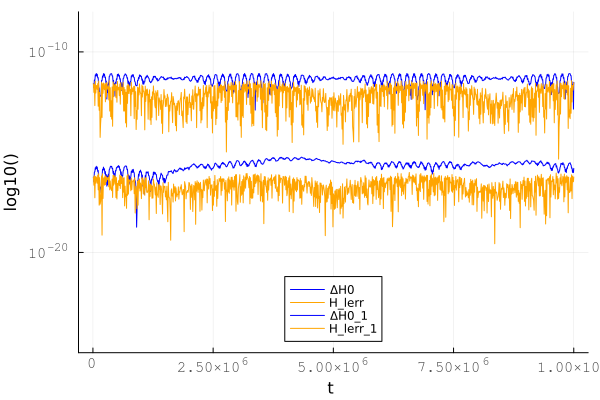

In [11]:
yrange=(1e-25,1e-8)
plot(title="",xlabel="t ", ylabel="log10()", 
     yscale=:log10, ylims=yrange,
     xtickfont = font(8, "Courier"),
     ytickfont = font(8, "Courier"),
     legend=:bottom)
plot!(sol.t,abs.(ΔH0),label="ΔH0", color="blue")
plot!(sol.t[2:end],abs.(H_lerr),label="H_lerr", color="orange")
plot!(sol.t,abs.(ΔH0_1),label="ΔH0_1", color="blue")
plot!(sol.t[2:end],abs.(H_lerr_1),label="H_lerr_1", color="orange")

In [12]:
sol.stats

SciMLBase.DEStats
Number of function 1 evaluations:                  11774504
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     1471813
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          416667
Number of rejected steps:                          0

<a href="#top">Back to the top</a>

## Error in solution

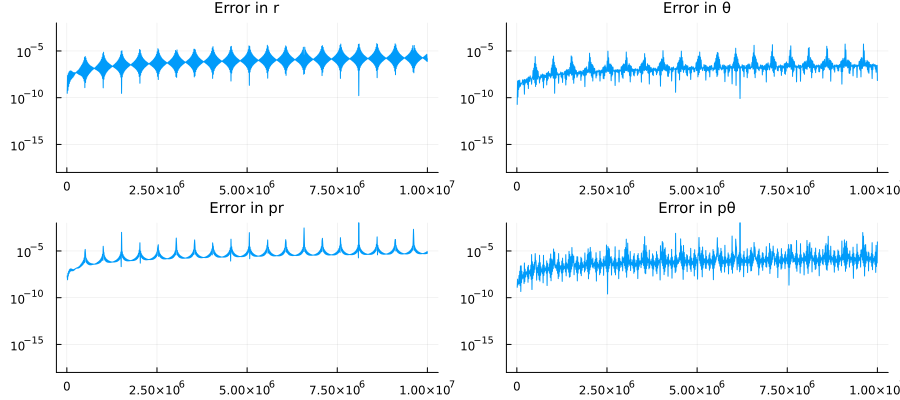

In [13]:
error_r=map((u,u1)->abs(BigFloat(u[1]/u1[1]-1)), sol.u[2:end], sol1.u[2:end])
error_θ=map((u,u1)->abs(BigFloat(u[2]/u1[2]-1)), sol.u[2:end], sol1.u[2:end])
error_pr=map((u,u1)->abs(BigFloat(u[3]/u1[3]-1)), sol.u[2:end], sol1.u[2:end])
error_pθ=map((u,u1)->abs(BigFloat(u[4]/u1[4]-1)), sol.u[2:end], sol1.u[2:end])

yrange=(1e-18,1e-2)
pl1=plot(sol.t[2:end], error_r, title="Error in r",  titlefontsize=10,
     yscale=:log10, xlabel="", ylabel="", ylimits=yrange, legend=false)
#
pl2=plot(sol.t[2:end], error_θ, title="Error in θ",  titlefontsize=10,
     yscale=:log10, xlabel="", ylabel="", ylimits=yrange, legend=false)
#
pl3=plot(sol.t[2:end], error_pr, title="Error in pr",  titlefontsize=10,
     yscale=:log10, xlabel="", ylabel="", ylimits=yrange, legend=false)
#
pl4=plot(sol.t[2:end], error_pθ, title="Error in pθ",  titlefontsize=10,
     yscale=:log10, xlabel="", ylabel="", ylimits=yrange, legend=false)

plot(pl1, pl2, pl3, pl4,
layout=(2,2), size=(900,400),plot_title="")